## Import modules

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from dataclasses import dataclass

### Helpers

#### Plot losses method

In [2]:
def plot_loss(losses_generator, losses_critic, title):
    """
    Plots the losses over the training iterations.

    Args:
        losses (list): List of loss values.
        title (str): The title of the plot.

    Returns:
        None
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    plt.plot(losses_generator, label="Generator")
    plt.plot(losses_critic, label="Critic")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.show()


#### Generate images method

In [3]:
def generate_images(generator, label, n_images=16, device='cuda', config=None):
    """
    Generates and displays fake images using a generator model.

    Parameters:
    - generator (torch.nn.Module): The generator model used to generate fake images.
    - label (int): The label to be assigned to the generated images.
    - n_images (int): The number of fake images to generate and display. Default is 16.
    - device (str): The device to use for generating the images. Default is 'cuda'.
    - config (object): Additional configuration options. Default is None.

    Returns:
    None
    """
    z = torch.randn(n_images, config.noise_dim, device=device)
    labels = torch.full((n_images,), label, dtype=torch.long, device=device)
    
    try:
        with torch.no_grad():
            fake_images = generator(z, labels).view(-1, 28, 28).cpu().numpy()
    except TypeError:
        with torch.no_grad():
            fake_images = generator(z).view(-1, 28, 28).cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(n_images):
        plt.subplot(4, 4, i+1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.show()


## Define a config dataclass

In [4]:
@dataclass
class Config:
    """
    Configuration class for the GAN model.

    Attributes:
        batch_size (int): The batch size for training.
        lr (float): The learning rate for the model.
        num_epochs (int): The number of epochs for training.
        noise_dim (int): The dimension of the noise for the generator.
        clip_value (float): The value used for weight clipping in WGAN.
        critic_iter (int): The number of iterations to train the critic for each generator iteration.
    """
    batch_size: int = 64
    lr: float = 0.00005
    num_epochs: int = 100
    noise_dim: int = 100
    clip_value: float = 0.01
    critic_iter: int = 5

config = Config()

## Load the dataset and define a train dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

## GAN

### Define a Critic class

In [6]:
class Critic(nn.Module):
    def __init__(self):
        """
        Critic class represents the critic network in a GAN model.

        The critic network is responsible for evaluating the quality of generated images.

        Attributes:
            model (nn.Sequential): The sequential model representing the critic network.

        """
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1))

    def forward(self, x):
        """
        Forward pass of the critic network.

        Args:
            x (torch.Tensor): Input tensor representing the images.

        Returns:
            torch.Tensor: Output tensor representing the critic's evaluation of the images.

        """
        x = x.view(x.size(0), -1)
        return self.model(x)


### Define a Generator class

In [7]:
class Generator(nn.Module):
    def __init__(self):
        """
        Initializes the Generator module.

        The Generator consists of a series of linear layers followed by
        leaky ReLU activation functions and a final Tanh activation function.

        Args:
            None

        Returns:
            None
        """
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28 * 28),
            nn.Tanh())

    def forward(self, z):
        """
        Performs forward pass through the Generator.

        Args:
            z (torch.Tensor): Input noise tensor of shape (batch_size, noise_dim).

        Returns:
            torch.Tensor: Generated output tensor of shape (batch_size, 28*28).
        """
        return self.model(z)

### Initializing Models and Optimizers

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

critic = Critic().to(device)
generator = Generator().to(device)

optim_critic = optim.RMSprop(critic.parameters(), lr=config.lr)
optim_generator = optim.RMSprop(generator.parameters(), lr=config.lr)


In [9]:
optim_critic = optim.RMSprop(critic.parameters(), lr=config.lr)
optim_generator = optim.RMSprop(generator.parameters(), lr=config.lr)


## Define a weight clipping function

In [10]:
def weight_clipping(model, clip_value):
    """
    Clips the weights of the given model to the specified range.

    Args:
        model (nn.Module): The model whose weights need to be clipped.
        clip_value (float): The maximum absolute value allowed for the weights.

    Returns:
        None
    """
    for param in model.parameters():
        param.data.clamp_(-clip_value, clip_value)

### GAN Training

In [11]:
losses_critic_wgan = []
losses_generator_wgan = []

# Training loop
for epoch in range(config.num_epochs):
    for i, (images, _) in enumerate(train_loader):

        # Working with real images
        real_images = images.to(device)
        real_images = real_images.view(real_images.size(0), -1)
        batch_size = real_images.size(0)

        # Critic training
        for _ in range(config.critic_iter):
            critic.zero_grad()

            # Real images
            real_pred = critic(real_images)
            real_loss = -torch.mean(real_pred)

            # Generate fake images and noises
            z = torch.randn(batch_size, config.noise_dim, device=device)
            fake_images = generator(z)
            fake_pred = critic(fake_images.detach())
            fake_loss = torch.mean(fake_pred)

            # Overall loss and optimization step
            critic_loss = real_loss + fake_loss
            critic_loss.backward()
            optim_critic.step()

            # Clip weights
            weight_clipping(critic, config.clip_value)

        # Generator training
        generator.zero_grad()

        # Getting critic's score for generated images
        gen_pred = critic(fake_images)
        generator_loss = -torch.mean(gen_pred)

        generator_loss.backward()
        optim_generator.step()

        # Saving loss values
        losses_critic_wgan.append(critic_loss.item())
        losses_generator_wgan.append(generator_loss.item())

        # Displaying training process information
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{config.num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {critic_loss.item()}, loss G: {generator_loss.item()}")



Epoch [1/100] Batch 0/938                   Loss D: -0.06258009374141693, loss G: -0.010116783902049065
Epoch [1/100] Batch 50/938                   Loss D: -0.6347735524177551, loss G: -0.9819719791412354
Epoch [1/100] Batch 100/938                   Loss D: -0.5435419082641602, loss G: -1.303762674331665
Epoch [1/100] Batch 150/938                   Loss D: 0.6121180057525635, loss G: -3.069465160369873
Epoch [1/100] Batch 200/938                   Loss D: 0.3209221363067627, loss G: 1.9601852893829346
Epoch [1/100] Batch 250/938                   Loss D: -0.9627584218978882, loss G: -1.647568941116333
Epoch [1/100] Batch 300/938                   Loss D: -3.775869369506836, loss G: 0.4156997501850128
Epoch [1/100] Batch 350/938                   Loss D: 0.6910308599472046, loss G: -1.7954189777374268
Epoch [1/100] Batch 400/938                   Loss D: -4.112393856048584, loss G: -1.5763572454452515
Epoch [1/100] Batch 450/938                   Loss D: -4.5136799812316895, loss G: 

### Plot the loss

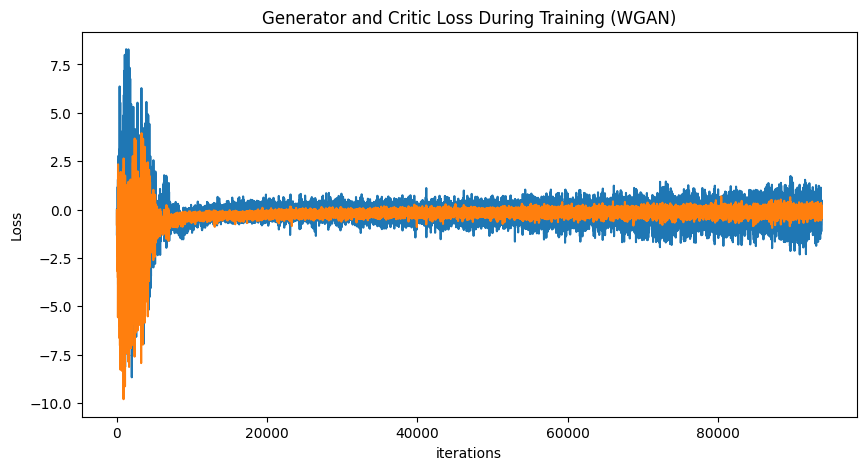

In [12]:
plot_loss(losses_generator_wgan, losses_critic_wgan, "Generator and Critic Loss During Training (WGAN)")

### Visualize the generated images

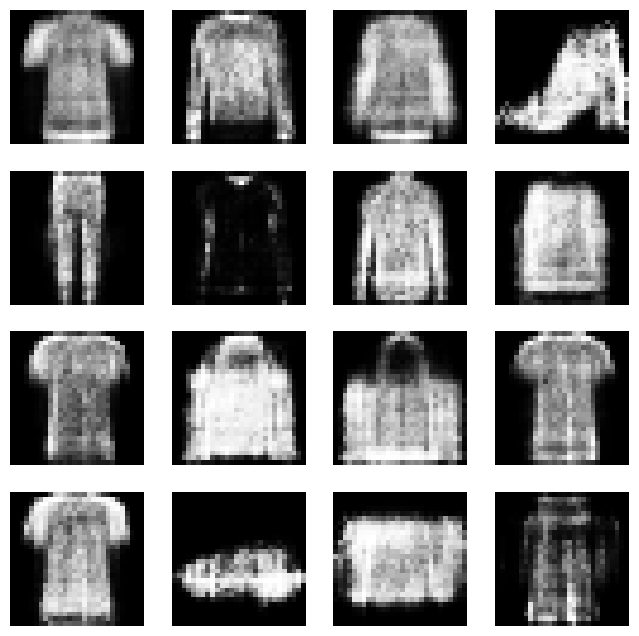

In [13]:
generate_images(generator=generator, label=7, config=config, device=device)

## Coditional GANs

### Define a Conditional Generator class

In [14]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
        """
        Conditional Generator class for generating images based on given labels.

        Args:
            None

        Returns:
            None
        """
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(config.noise_dim + 10, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh())

    def forward(self, z, labels):
        """
        Forward pass of the Conditional Generator.

        Args:
            z (torch.Tensor): Input noise tensor of shape (batch_size, noise_dim).
            labels (torch.Tensor): Input label tensor of shape (batch_size).

        Returns:
            torch.Tensor: Generated image tensor of shape (batch_size, 28*28).
        """
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)


### Define a Conditional Critic class

In [15]:
class ConditionalCritic(nn.Module):
    """
    ConditionalCritic class represents a critic network for conditional GANs.

    Args:
        None

    Attributes:
        label_emb (nn.Embedding): Embedding layer for label embeddings.
        model (nn.Sequential): Sequential model for the critic network.

    Methods:
        forward(img, labels): Performs forward pass of the critic network.

    """

    def __init__(self):
        super(ConditionalCritic, self).__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1))

    def forward(self, img, labels):
        """
        Performs forward pass of the critic network.

        Args:
            img (torch.Tensor): Input image tensor.
            labels (torch.Tensor): Input label tensor.

        Returns:
            torch.Tensor: Output tensor from the critic network.

        """
        # Embed labels and concatenate them with the image
        c = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), c], 1)
        return self.model(x)


### Initialize conditional GAN

In [16]:
conditional_generator = ConditionalGenerator().to(device)
conditional_critic = ConditionalCritic().to(device)

### Initializing Optimizers for Conditional Models

In [17]:
optim_conditional_critic = optim.RMSprop(conditional_critic.parameters(), lr=config.lr)
optim_conditional_generator = optim.RMSprop(conditional_generator.parameters(), lr=config.lr)

### Conditional GAN Training

In [18]:
losses_critic_conditional = []
losses_generator_conditional = []

for epoch in range(config.num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Preparing data
        real_images = images.to(device).view(images.size(0), -1)
        labels = labels.to(device)
        batch_size = real_images.size(0)
        real_labels = torch.full((batch_size, 1), 1, device=device)
        fake_labels = torch.full((batch_size, 1), 0, device=device)

        # Training conditional critic
        for _ in range(config.critic_iter):
            conditional_critic.zero_grad()

            # Real images
            real_pred = conditional_critic(real_images, labels)
            real_loss = -torch.mean(real_pred)

            # Fake images
            z = torch.randn(batch_size, config.noise_dim, device=device)
            fake_images = conditional_generator(z, labels)
            fake_pred = conditional_critic(fake_images.detach(), labels)
            fake_loss = torch.mean(fake_pred)

            # Total loss and optimization step
            critic_loss = real_loss + fake_loss
            critic_loss.backward()
            optim_conditional_critic.step()

            # Weight clipping
            weight_clipping(conditional_critic, config.clip_value)

        # Training conditional generator
        conditional_generator.zero_grad()

        # Generating noise and labels
        gen_pred = conditional_critic(fake_images, labels)
        generator_loss = -torch.mean(gen_pred)

        generator_loss.backward()
        optim_conditional_generator.step()

        # Saving loss values
        losses_critic_conditional.append(critic_loss.item())
        losses_generator_conditional.append(generator_loss.item())

        # Displaying training process information
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{config.num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {critic_loss.item()}, loss G: {generator_loss.item()}")



Epoch [1/100] Batch 0/938                   Loss D: -0.05669008567929268, loss G: 0.008984019048511982
Epoch [1/100] Batch 50/938                   Loss D: -0.7530719041824341, loss G: -0.7625920176506042
Epoch [1/100] Batch 100/938                   Loss D: -1.7672491073608398, loss G: 0.7351241111755371
Epoch [1/100] Batch 150/938                   Loss D: 1.8552744388580322, loss G: -2.1032094955444336
Epoch [1/100] Batch 200/938                   Loss D: 0.02260887622833252, loss G: 1.455773115158081
Epoch [1/100] Batch 250/938                   Loss D: -2.297538995742798, loss G: -1.6599297523498535
Epoch [1/100] Batch 300/938                   Loss D: -2.1274642944335938, loss G: -1.84482741355896
Epoch [1/100] Batch 350/938                   Loss D: -4.072976112365723, loss G: 1.8616175651550293
Epoch [1/100] Batch 400/938                   Loss D: 1.3363285064697266, loss G: -7.788217544555664
Epoch [1/100] Batch 450/938                   Loss D: -5.115614891052246, loss G: 1.1

### Visualize the loss

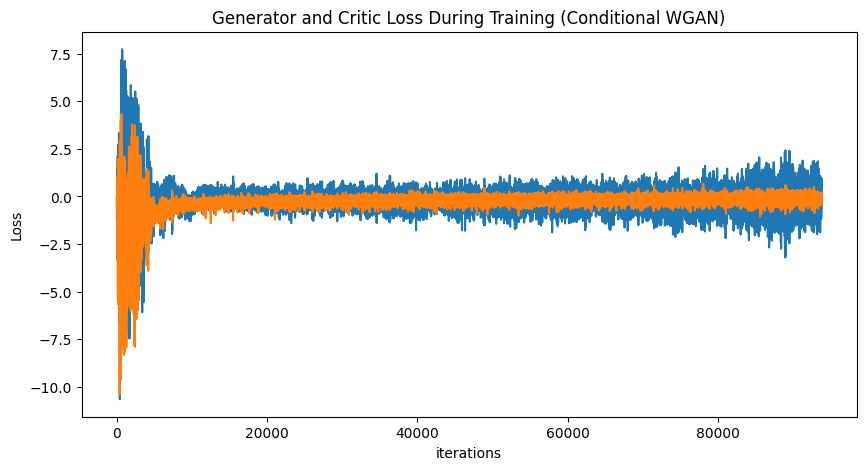

In [19]:
plot_loss(losses_generator_conditional, losses_critic_conditional, "Generator and Critic Loss During Training (Conditional WGAN)")


### Generate images

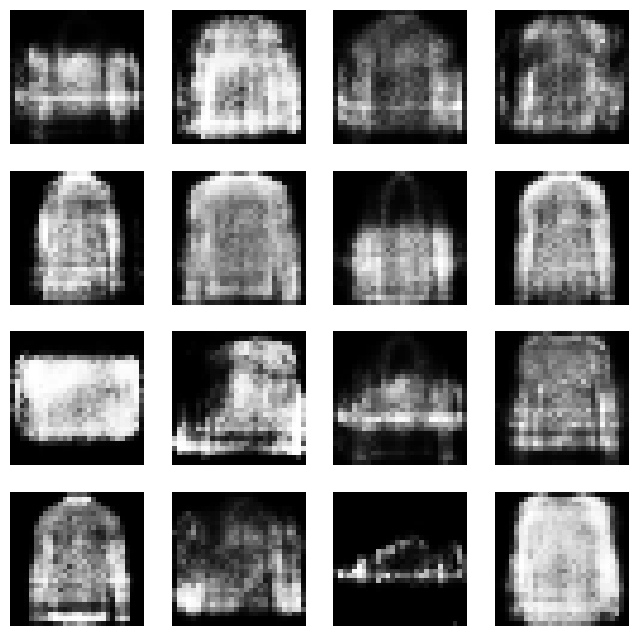

In [20]:
generate_images(conditional_generator, label=2, config=config, device=device)


## WGAN-GP

### Define a Gradient penalty method

In [21]:
def compute_gradient_penalty(critic, real_samples, fake_samples, labels):
    """
    Computes the gradient penalty for the critic in a GAN model.

    Parameters:
    - critic (torch.nn.Module): The critic model.
    - real_samples (torch.Tensor): Real samples from the dataset.
    - fake_samples (torch.Tensor): Fake samples generated by the generator.
    - labels (torch.Tensor): Labels for the samples.

    Returns:
    - gradient_penalty (torch.Tensor): The computed gradient penalty.
    """
    alpha = torch.rand((real_samples.size(0), 1), device=device).expand_as(real_samples)
    interpolated_samples = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated_samples.requires_grad_(True)

    # Critic evaluation on interpolated samples
    interpolated_pred = critic(interpolated_samples, labels)

    # Gradient calculation
    gradients = torch.autograd.grad(
        outputs=interpolated_pred, inputs=interpolated_samples,
        grad_outputs=torch.ones(interpolated_pred.size(), device=device),
        create_graph=True, retain_graph=True, only_inputs=True)[0]

    # Gradient norm and penalty
    gradients_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradients_norm - 1) ** 2).mean()
    return gradient_penalty


### WGAN-GP training

In [22]:
lambda_gp = 10
losses_critic_wgangp = []
losses_generator_wgangp = []

for epoch in range(config.num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        real_images = images.to(device).view(images.size(0), -1)
        labels = labels.to(device)
        batch_size = real_images.size(0)

        # Training conditional critic
        conditional_critic.zero_grad()

        # Real images
        real_pred = conditional_critic(real_images, labels)
        real_loss = -torch.mean(real_pred)

        # Fake images
        z = torch.randn(batch_size, config.noise_dim, device=device)
        fake_images = conditional_generator(z, labels)
        fake_pred = conditional_critic(fake_images.detach(), labels)
        fake_loss = torch.mean(fake_pred)

        # Calculating gradient penalty
        gradient_penalty = compute_gradient_penalty(conditional_critic, real_images, fake_images.detach(), labels)
        critic_loss = real_loss + fake_loss + lambda_gp * gradient_penalty

        critic_loss.backward()
        optim_conditional_critic.step()

        # Training conditional generator
        conditional_generator.zero_grad()

        # Regenerating fake images
        fake_images = conditional_generator(z, labels)
        gen_pred = conditional_critic(fake_images, labels)
        generator_loss = -torch.mean(gen_pred)

        generator_loss.backward()
        optim_conditional_generator.step()

        # Saving loss values
        losses_critic_wgangp.append(critic_loss.item())
        losses_generator_wgangp.append(generator_loss.item())

        # Displaying training process information
        if i % 50 == 0:
            print(f"Epoch [{epoch+1}/{config.num_epochs}] Batch {i}/{len(train_loader)} \
                  Loss D: {critic_loss.item()}, loss G: {generator_loss.item()}")



Epoch [1/100] Batch 0/938                   Loss D: 6.844859600067139, loss G: -0.44810807704925537
Epoch [1/100] Batch 50/938                   Loss D: 4.801741123199463, loss G: 0.3338942527770996
Epoch [1/100] Batch 100/938                   Loss D: 3.631098508834839, loss G: -5.372400283813477
Epoch [1/100] Batch 150/938                   Loss D: 0.3995198607444763, loss G: -12.446070671081543
Epoch [1/100] Batch 200/938                   Loss D: 0.13975636661052704, loss G: -9.390214920043945
Epoch [1/100] Batch 250/938                   Loss D: -0.2985510230064392, loss G: -8.329948425292969
Epoch [1/100] Batch 300/938                   Loss D: 0.7198670506477356, loss G: -9.313689231872559
Epoch [1/100] Batch 350/938                   Loss D: -0.39600488543510437, loss G: -6.723268508911133
Epoch [1/100] Batch 400/938                   Loss D: -0.04908250272274017, loss G: -6.784772872924805
Epoch [1/100] Batch 450/938                   Loss D: -0.2593401074409485, loss G: -5.88

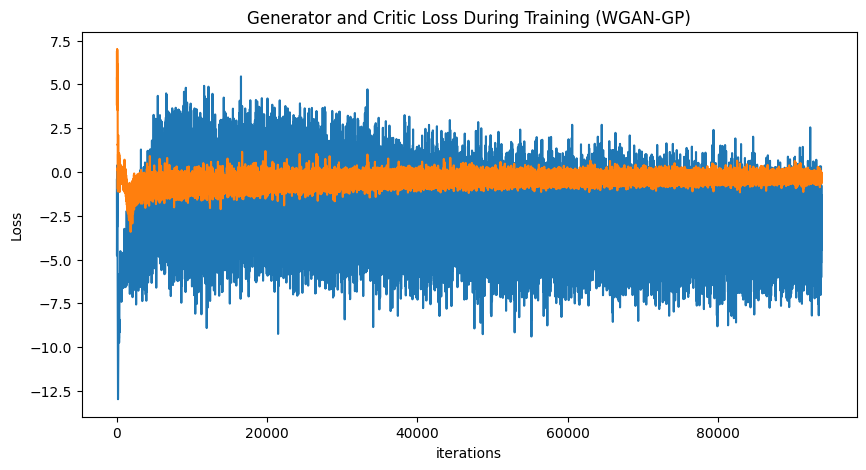

In [23]:
plot_loss(losses_generator_wgangp, losses_critic_wgangp, "Generator and Critic Loss During Training (WGAN-GP)")

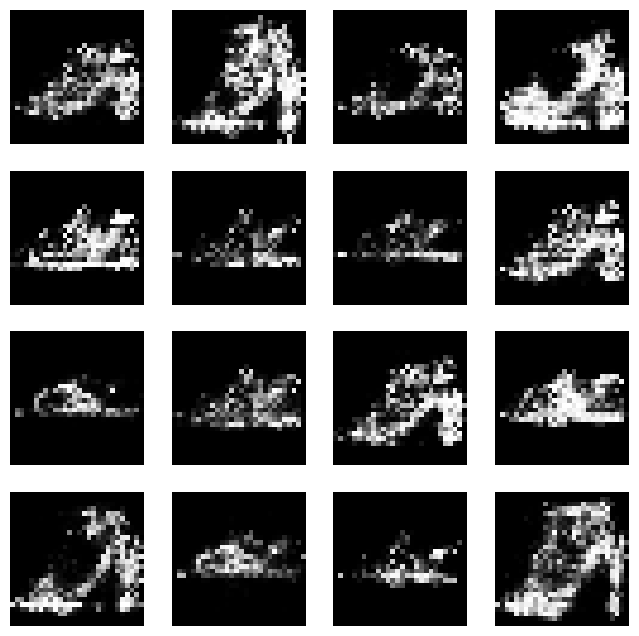

In [24]:
generate_images(conditional_generator, label=5, config=config, device=device)
